1. Set up and Import

We decided to process out model through a Google Collab sheet so that we would all have access through a common interface. To achieve this, we needed to do the following:

- Download the dataset off of the TALC cluster to our local machine
- Upload the tar.gz zipped folder to our Google Drive
- Extract the files to a local working folder

In [ ]:
# Mount to Google Drive so that we can access the uploaded dataset:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Extract dataset from the tar.gz file uploaded to Google Drive:
!tar -xzvf "/content/drive/MyDrive/cvpr_2024_dataset.tar.gz" -C "/content/Data"


Streaming output truncated to the last 5000 lines.
Train/Blue/flyer_1995.png
Train/Blue/empty_samosa_cardboard_1747.png
Train/Blue/Electronics_Box_1459.png
Train/Blue/cloth_bag_1085.png
Train/Blue/french_fry_box_2173.png
Train/Blue/empty_sauce_bottle_1748.png
Train/Blue/empty_pill_bottle_1697.png
Train/Blue/IMG_WA_2698.png
Train/Blue/end_of_food_glass_container_1821.png
Train/Blue/dirty_cake_wrapper_min_1325.png
Train/Blue/empty_sesame_oil_1750.png
Train/Blue/empty_toilet_paper_roll_1491.png
Train/Blue/dental_floss_1285.png
Train/Blue/coke_can_1163.png
Train/Blue/empty_candle_container_1536.png
Train/Blue/empty_mayonnaise_plastic_bottle_1643.png
Train/Blue/cookies_cardboard_package_1194.png
Train/Blue/dirty_plastic_container__1354.png
Train/Blue/Dirty_plastic_box_1311.png
Train/Blue/food_metal_can_2120.png
Train/Blue/empty_plastic_botle_1706.png
Train/Blue/empty_tissue_box_1778.png
Train/Blue/ice_tea_metal_can_2660.png
Train/Blue/gum_paper_container_2605.png
Train/Blue/empty_medicine_1

In [ ]:
# Necessary imports for the project:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image


2. Dataset Preparation

We created a custom dataset class to handle the loading and transforming of the images for each subset (training, validation, and testing). The transformer we used is defined further below:


In [ ]:
# Custon class used to represent the train, validation, and test sets:
class GarbageDataset(Dataset):

    # Constructor that initializes storage and loads in all images from the specified sub-directory:
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load all images from sub-directories:
        for label, class_dir in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_dir)
            for image_name in os.listdir(class_path):
                self.images.append(os.path.join(class_path, image_name))
                self.labels.append(label)

    # Getter to return the number of image samples in the dataset:
    def __len__(self):
        return len(self.images)

    # Gets an image and classification label from the dataset at a specified index:
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


3. Data Loading and Transformation (Preprocessing)

The code below sets up the data loading and preprocessing steps that we decided to use for this assignment. It first defines a series of transformations to resize the images to 256x256 pixels, convert them to tensor format, and normalize them using the mean and standard deviation values from the ImageNet dataset.

These transformations are then applied to the training, validation, and test datasets through the GarbageDataset class that we defined above. These are then loaded using PyTorch's DataLoader to specify batch sizes and shuffle the training dataset only.


In [ ]:
# Define the transformation that will be applied on all of the input data
transform = transforms.Compose([
    transforms.Resize((256, 256)),    # Pad images if necessary (reshape to square)
    transforms.ToTensor(),            # For PyTorch processing

    # Values used for normalization are the same as from the ImageNet dataset:
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming the dataset is split into 'train', 'val', and 'test' directories:
train_dataset = GarbageDataset(root_dir='/content/Data/Train', transform=transform)
val_dataset = GarbageDataset(root_dir='/content/Data/Validation', transform=transform)
test_dataset = GarbageDataset(root_dir='/content/Data/Test', transform=transform)

# Create dataLoader objects which batch (size = 64) and shuffle the training data:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


4. Model Definition

We decided to apply transfer learning using the pre-trained ResNet18 model (trained on ImageNet dataset). Initial weights are loaded in, and will be adjusted using our smaller dataset. We also specify that we want to use a GP and print out what device is used for confirmation.


In [ ]:
# Instantiate the Resnet18 model using standard weights (did not implement freezing of layers):
model = torchvision.models.resnet18(weights=True)
num_ftrs = model.fc.in_features   # Define features to use from Resnet18
num_classes = 4                   # Define number of unique classification classes

# Adjust the final layer based on the number of classes:
model.fc = nn.Linear(num_ftrs, num_classes)

# Check if a GPU is available and move the model to GPU if possible:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)
model = model.to(device)


Device used: cuda


5. Loss Function and Optimizer

Below, we define out loss function criteria (Cross Entropy) and optimizer (Stochastic Gradient Descent) that are used for learning. We played with the learning rate and momentum parameters in the optimizer, which resulted in the following results from initial tests:

-
- MODEL 1 --> (learning rate = 0.001, momentum = 0.9)

Epoch 1, Train Loss: 0.8800, Train Accuracy: 65.31%, Val Loss: 0.7135, Val Accuracy: 72.25%

Epoch 2, Train Loss: 0.5878, Train Accuracy: 77.53%, Val Loss: 0.6346, Val Accuracy: 76.45%

Epoch 3, Train Loss: 0.4817, Train Accuracy: 81.56%, Val Loss: 0.6240, Val Accuracy: 77.00%

Epoch 4, Train Loss: 0.3935, Train Accuracy: 84.92%, Val Loss: 0.6132, Val Accuracy: 77.00%

Epoch 5, Train Loss: 0.3022, Train Accuracy: 89.33%, Val Loss: 0.6332, Val Accuracy: 77.85%

<font color="green">Epoch 6, Train Loss: 0.2255, Train Accuracy: 92.70%, Val Loss: 0.6468, Val Accuracy: 77.70%</font>

Epoch 7, Train Loss: 0.1577, Train Accuracy: 95.30%, Val Loss: 0.6794, Val Accuracy: 77.85%

Epoch 8, Train Loss: 0.1035, Train Accuracy: 97.71%, Val Loss: 0.7007, Val Accuracy: 77.40%

Epoch 9, Train Loss: 0.0720, Train Accuracy: 98.88%, Val Loss: 0.7579, Val Accuracy: 76.90%

Epoch 10, Train Loss: 0.0476, Train Accuracy: 99.33%, Val Loss: 0.7842, Val Accuracy: 77.60%

Epoch 11, Train Loss: 0.0373, Train Accuracy: 99.54%, Val Loss: 0.8139, Val Accuracy: 77.65%
### The initial model (learning rate = 0.001, momentum = 0.9) achieved the highest validation accuracy (77.85%) at epoch 6. However, the model was definitely overfitting as the training accuracy at this epoch was 92.70%. This led us to decrease the learning rate by a factor of 10 for all other tests.

-
- MODEL 2 --> (learning rate = 0.0001, momentum = 0.8)
Epoch 1, Train Loss: 1.2542, Train Accuracy: 45.15%, Val Loss: 1.1900, Val Accuracy: 49.55%

Epoch 2, Train Loss: 1.1003, Train Accuracy: 54.96%, Val Loss: 1.0761, Val Accuracy: 57.55%

Epoch 3, Train Loss: 1.0007, Train Accuracy: 61.12%, Val Loss: 0.9979, Val Accuracy: 62.45%

Epoch 4, Train Loss: 0.9261, Train Accuracy: 65.36%, Val Loss: 0.9374, Val Accuracy: 65.05%

Epoch 5, Train Loss: 0.8699, Train Accuracy: 68.24%, Val Loss: 0.8923, Val Accuracy: 67.30%

Epoch 6, Train Loss: 0.8270, Train Accuracy: 69.92%, Val Loss: 0.8573, Val Accuracy: 68.70%

Epoch 7, Train Loss: 0.7919, Train Accuracy: 71.24%, Val Loss: 0.8303, Val Accuracy: 69.10%

Epoch 8, Train Loss: 0.7630, Train Accuracy: 72.00%, Val Loss: 0.8065, Val Accuracy: 70.00%

Epoch 9, Train Loss: 0.7387, Train Accuracy: 72.91%, Val Loss: 0.7877, Val Accuracy: 70.55%

Epoch 10, Train Loss: 0.7187, Train Accuracy: 73.56%, Val Loss: 0.7729, Val Accuracy: 70.75%

Epoch 11, Train Loss: 0.7003, Train Accuracy: 74.25%, Val Loss: 0.7571, Val Accuracy: 71.75%

Epoch 12, Train Loss: 0.6863, Train Accuracy: 74.47%, Val Loss: 0.7507, Val Accuracy: 71.95%

Epoch 13, Train Loss: 0.6710, Train Accuracy: 75.04%, Val Loss: 0.7390, Val Accuracy: 72.35%

Epoch 14, Train Loss: 0.6567, Train Accuracy: 75.35%, Val Loss: 0.7285, Val Accuracy: 72.45%

Epoch 15, Train Loss: 0.6479, Train Accuracy: 75.78%, Val Loss: 0.7202, Val Accuracy: 72.65%

<font color="green">Epoch 16, Train Loss: 0.6333, Train Accuracy: 76.19%, Val Loss: 0.7131, Val Accuracy: 72.85%</font>

Epoch 17, Train Loss: 0.6259, Train Accuracy: 76.44%, Val Loss: 0.7070, Val Accuracy: 73.00%

Epoch 18, Train Loss: 0.6156, Train Accuracy: 76.89%, Val Loss: 0.7016, Val Accuracy: 73.60%

Epoch 19, Train Loss: 0.6040, Train Accuracy: 77.26%, Val Loss: 0.6955, Val Accuracy: 73.35%

Epoch 20, Train Loss: 0.5956, Train Accuracy: 77.35%, Val Loss: 0.6920, Val Accuracy: 73.30%

Epoch 21, Train Loss: 0.5867, Train Accuracy: 77.71%, Val Loss: 0.6863, Val Accuracy: 73.80%

Epoch 22, Train Loss: 0.5790, Train Accuracy: 77.90%, Val Loss: 0.6847, Val Accuracy: 73.30%

### The second model (learning rate = 0.0001, momentum = 0.8) achieved the highest validation accuracy (72.85%) at epoch 16. However, the model was showing less signs of overfitting as the training accuracy at this epoch was 76.19%. For our final model, we used the same learning rate, but increased the momentum back to 0.9 as can be seen below:

In [ ]:
# We use CrossEntropy loss function and the SGD optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

6. Training Loop

We chose to implement a training loop with validation occuring in each epoch so that we could track results from each epoch and monitor when to stop. The alternative to this approach would have been to implement a stopping function, but we wanted to let it run past this spot initially as we wanted to see how the model looked while overtraining.


In [ ]:
# Epochs were decided after initial testing beyond this number:
num_epochs = 16

for epoch in range(num_epochs):

    # Set model to training mode:
    model.train()

    # Initialize tracking parameters:
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase:
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Clear gradients from previous epoch:
        optimizer.zero_grad()

        # Implement forward pass:
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Implement backward pass:
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Convert outputs to predicted class labels:
        _, predicted = torch.max(outputs.data, 1)

        # Update count of processed labels and correctly predicted labels:
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy for current epoch:
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase:

    # Set the model to evaluation mode:
    model.eval()

    # Initialize tracking parameters:
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    # Iterate through batches without tracking gradients:
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Convert outputs to predicted class labels:
            _, predicted = torch.max(outputs.data, 1)

            # Update count of processed labels and correctly predicted labels:
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy for current epoch:
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Output current epoch losses and accuracies:
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')


Epoch 1, Train Loss: 1.2184, Train Accuracy: 47.58%, Val Loss: 1.0738, Val Accuracy: 58.70%
Epoch 2, Train Loss: 0.9842, Train Accuracy: 62.38%, Val Loss: 0.9315, Val Accuracy: 65.60%
Epoch 3, Train Loss: 0.8612, Train Accuracy: 68.10%, Val Loss: 0.8477, Val Accuracy: 69.05%
Epoch 4, Train Loss: 0.7887, Train Accuracy: 70.61%, Val Loss: 0.8004, Val Accuracy: 70.05%
Epoch 5, Train Loss: 0.7396, Train Accuracy: 72.66%, Val Loss: 0.7655, Val Accuracy: 71.25%
Epoch 6, Train Loss: 0.7022, Train Accuracy: 73.78%, Val Loss: 0.7403, Val Accuracy: 72.25%
Epoch 7, Train Loss: 0.6727, Train Accuracy: 74.72%, Val Loss: 0.7212, Val Accuracy: 73.20%
Epoch 8, Train Loss: 0.6438, Train Accuracy: 75.53%, Val Loss: 0.7050, Val Accuracy: 73.25%
Epoch 9, Train Loss: 0.6265, Train Accuracy: 76.36%, Val Loss: 0.6952, Val Accuracy: 73.30%
Epoch 10, Train Loss: 0.6056, Train Accuracy: 76.94%, Val Loss: 0.6857, Val Accuracy: 73.50%
Epoch 11, Train Loss: 0.5911, Train Accuracy: 77.49%, Val Loss: 0.6759, Val Acc

### The final model (learning rate = 0.0001, momentum = 0.9) achieved a validation accuracy (75.10%) at epoch 16, which is slightly higher than our second model. The training accuracy was 80.79% for this epoch.

7. Evaluation Metrics and Testing

Below is our blocks of code that evaluate the model using the testing data. We focused on evaluating the model using metrics such as accuracy, precision, recall, and f-score. We also presented the confusion matrix showing insight into how the results looked for each class.

In [ ]:
# Function defined to evaluate model using our test dataset:
def evaluate_model(model, data_loader):

    # Set model to evaluate mode
    model.eval()

    # Initialize tracking parameters:
    total = 0
    correct = 0
    all_preds = []
    all_labels = []

    # Iterate through batches without tracking gradients:
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Convert outputs to predicted class labels:
            _, predicted = torch.max(outputs, 1)

            # Update count of processed labels and correctly predicted labels:
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels:
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Calculate accuracy and return results:
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels


Test Accuracy: 73.00%


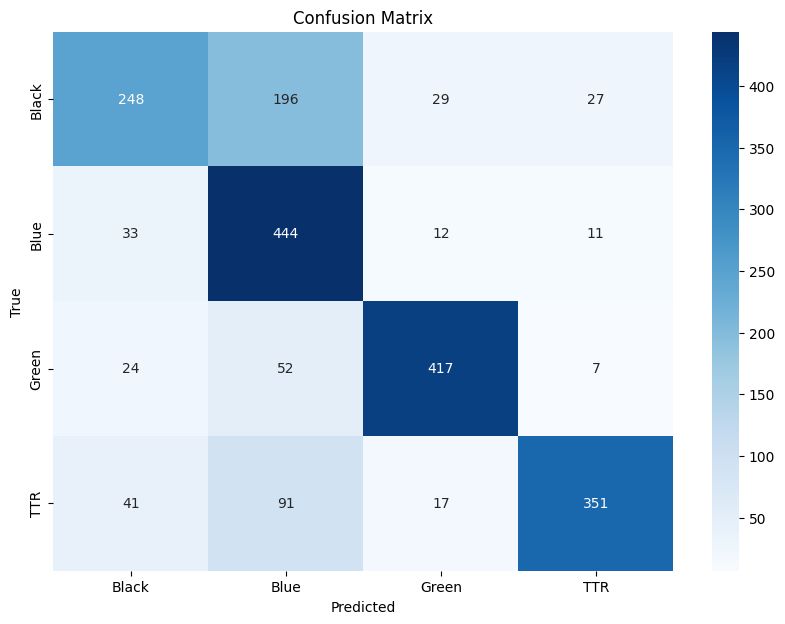

              precision    recall  f1-score   support

       Black       0.72      0.50      0.59       500
        Blue       0.57      0.89      0.69       500
       Green       0.88      0.83      0.86       500
         TTR       0.89      0.70      0.78       500

    accuracy                           0.73      2000
   macro avg       0.76      0.73      0.73      2000
weighted avg       0.76      0.73      0.73      2000



In [ ]:
# Evaluate test dataset using function defined in block above:
test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Define and plot confusion Matrix:
cm = confusion_matrix(test_labels, test_preds)
class_names = ['Black', 'Blue', 'Green', 'TTR']
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Output classification Report:
print(classification_report(test_labels, test_preds, target_names=class_names))


Looking at the confusion matrix above, it can be seen that images of garbage that should go in the black bin were often classified as things that should be recycled in the blue bin (196 instances). The blue bin classifications were the most likely to be classified correctly, while the black bin classifications were the least likely to be classified correctly. The highest f1-score was for the green bin objects, which shows that there is a good balance between precision and recall.

Above, we provided a model for garbage classification that is trained, validated, and tested. The final model testing accuracy was 73%. This could be improved further by augmenting the dataset or getting more data. We also had access to key words for each image, which could be leveraged in future experimentation into a multi-modal classification model.
